# Hybrid recomendation system

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from surprise import SVD, Dataset, Reader
from surprise.model_selection import train_test_split
from evaluation import calculate_mse_and_rmse
from converter import to_df

In [15]:
ratings = pd.read_csv('data/ratings_small.csv', low_memory=False)
ratings = ratings.drop('timestamp', axis=1)
df_movies_cnt = pd.DataFrame(ratings.groupby('movieId').size(), columns=['count'])
popular_movies = list(set(df_movies_cnt.query('count >= 0').index))
movies_filter = ratings.movieId.isin(popular_movies).values

df_users_cnt = pd.DataFrame(ratings.groupby('userId').size(), columns=['count'])
active_users = list(set(df_users_cnt.query('count >= 0').index))
users_filter = ratings.userId.isin(active_users).values

ratings = ratings[movies_filter & users_filter]
reader = Reader()
ratings_by_users = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)
ratings_train, ratings_test = train_test_split(ratings_by_users, test_size=0.2, random_state=41)

In [16]:
ratings = to_df(ratings_train)
test_df = [{'userId': obj[0], 'movieId': obj[1], 'rating': obj[2]} for obj in ratings_test]
test_df = pd.DataFrame(test_df)

In [17]:
movie_metadata = pd.read_csv("data/movie_metadata_soup.csv", low_memory=False)
movie_metadata.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,tagline,title,video,vote_average,vote_count,cast,crew,keywords,director,soup
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"['animation', 'comedy', 'family']",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,NaN,Toy Story,False,7.7,5415.0,"['tomhanks', 'timallen', 'donrickles', 'jimvar...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...","['jealousy', 'toy', 'boy', 'friendship', 'frie...",johnlasseter,jealousy toy boy friendship friends tomhanks t...
1,False,NaN,65000000,"['adventure', 'fantasy', 'family']",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,"['robinwilliams', 'jonathanhyde', 'kirstenduns...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...","['boardgame', 'disappearance', ""basedonchildre...",joejohnston,boardgame disappearance basedonchildren'sbook ...
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"['romance', 'comedy']",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0,"['waltermatthau', 'jacklemmon', 'ann-margret',...","[{'credit_id': '52fe466a9251416c75077a89', 'de...","['fishing', 'bestfriend', 'duringcreditsstinge...",howarddeutch,fishing bestfriend duringcreditsstinger oldmen...
3,False,NaN,16000000,"['comedy', 'drama', 'romance']",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0,"['whitneyhouston', 'angelabassett', 'lorettade...","[{'credit_id': '52fe44779251416c91011acb', 'de...","['basedonnovel', 'interracialrelationship', 's...",forestwhitaker,basedonnovel interracialrelationship singlemot...
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,['comedy'],NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0,"['stevemartin', 'dianekeaton', 'martinshort', ...","[{'credit_id': '52fe44959251416c75039ed7', 'de...","['baby', 'midlifecrisis', 'confidence', 'aging...",charlesshyer,baby midlifecrisis confidence aging daughter s...


In [18]:
count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(movie_metadata['soup'])
count_matrix.shape

(46488, 102487)

In [19]:
cosine_sim = cosine_similarity(count_matrix, count_matrix)
cosine_sim.shape

(46488, 46488)

In [20]:
indices = pd.Series(movie_metadata.index, index=movie_metadata['id'])
indices = indices.sort_values(ascending=False)

In [21]:
def estimate_content_based(user_id, movies):
    user_ratings = pd.merge(ratings[ratings['userId'] == user_id],
                            movie_metadata[['id', 'title']],
                            left_on='movieId',
                            right_on='id',
                            how='inner')
    user_ratings = user_ratings.drop('id', axis=1)
    user_ratings['movieId'] = user_ratings['movieId'].astype(int)

    reviewed_movie_ids = set(user_ratings['movieId'])
    pred_series = []
    for movie_id in movies['id']:
        if movie_id in reviewed_movie_ids:
            continue
        simTotal = weightedSum = 0
        sim_scores_row = list(enumerate(cosine_sim[indices[movie_id]]))
        for reviewed_id in reviewed_movie_ids:
            idx = indices[reviewed_id]
            if len(sim_scores_row) < 46488:
                continue
            if type(idx) != np.int64:
                continue
            sim_score = sim_scores_row[idx]
            simTotal += float(sim_score[1])
            weightedSum += float(sim_score[1]) * float(user_ratings[user_ratings['movieId'] == reviewed_id]['rating'])
        predictedRating = weightedSum / simTotal if simTotal != 0 else 0
        pred_series.append((movie_id, predictedRating))

    pred_series = sorted(pred_series, key=lambda x: x[1], reverse=True)[:10]
    return pred_series

In [22]:
def get_recommendations_single_movie_content(id, rating, cosine_sim=cosine_sim):
    idx = indices[id]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = [(i, score * rating) for i, score in sim_scores]
    sim_scores = sorted(sim_scores, key=lambda x: x[1].any(), reverse=True)
    sim_scores = sim_scores[1:11]
    movie_indices = [i[0] for i in sim_scores]
    movie_metadata1 = movie_metadata[['id', 'title']].iloc[movie_indices]
    sim_scores_values = [i[1] for i in sim_scores]
    movie_metadata1['similarity_score'] = sim_scores_values
    return movie_metadata1

In [23]:
def get_recommendations_content(user_id):
    pred_series = []
    user_ratings = ratings.loc[ratings['userId'] == user_id]
    merged_ratings = pd.merge(user_ratings, movie_metadata[['id']], left_on='movieId', right_on='id', how='inner')
    top_10_user_ratings = merged_ratings.sort_values(by='rating', ascending=False).head(10)
    top_10_user_ratings['movieId'] = top_10_user_ratings['movieId'].astype(int)
    top_10_movie_ids = top_10_user_ratings[['movieId', 'rating']]
    for index, row in top_10_movie_ids.iterrows():
        movie_id = row['movieId']
        rating = row['rating']
        pred_series.append(get_recommendations_single_movie_content(movie_id, rating))
    df = pd.concat(pred_series)
    df = df.drop_duplicates(subset=['id'])
    df = df[pd.to_numeric(df['similarity_score'], errors='coerce').notnull()]
    df = df.sort_values(by='similarity_score', ascending=False)
    return pd.merge(pd.DataFrame(estimate_content_based(user_id, df),
                                 columns=['id', 'predicted_rating']), movie_metadata[['id', 'title']], on='id',
                    how='inner')

In [24]:
ratings_test = pd.merge(test_df, movie_metadata[['id']], left_on='movieId', right_on='id', how='inner')
ratings_test.head()

,userId,movieId,rating,id
0,472,750,5.0,750
1,575,750,5.0,750
2,118,750,5.0,750
3,520,750,4.5,750
4,549,750,5.0,750


In [25]:
svd_model = SVD()
svd_model_trained = svd_model.fit(ratings_train)

In [26]:
def get_recommendations_user(user_id):
    pred_series = []
    users_ratings = ratings[ratings['userId'] == user_id]
    for movie_id, name in zip(movie_metadata.index, movie_metadata['title']):
        rating_real = ratings.query(f'movieId == {movie_id}')['rating'].values[0] if movie_id in users_ratings[
            'movieId'].values else 0
        rating_pred = svd_model_trained.predict(user_id, movie_id, rating_real, verbose=False)
        pred_series.append([movie_id, name, rating_pred.est, rating_real])

    df_recommendations = pd.DataFrame(pred_series, columns=['movieId', 'title', 'predicted_rating', 'actual_rating'])
    return df_recommendations.sort_values(by='predicted_rating', ascending=False)

In [27]:
def predict_switching(user_id, movie_id, rating):
    num_user_ratings = len(ratings[ratings['userId'] == user_id])
    num_movie_ratings = len(ratings[ratings['movieId'] == movie_id])
    if num_user_ratings > 5 and num_movie_ratings > 30:
        return svd_model_trained.predict(user_id, movie_id, rating, verbose=False).est
    else:
        return estimate_content_based(user_id, movie_metadata[movie_metadata['id'] == movie_id])[0][1]


data = []
for index, row in ratings_test.iterrows():
    user_id = row['userId']
    movie_id = row['movieId']
    rating = row['rating']
    predicted = predict_switching(user_id, movie_id, rating)
    data.append((rating, predicted))


In [28]:
mse, rmse = calculate_mse_and_rmse(data)
print("MSE:", mse)
print("RMSE:", rmse)

MSE: 0.9150904342091895
RMSE: 0.9566035930358977


In [29]:
def predict_weighted(user_id, movie_id, rating):
    prediction_cf = svd_model_trained.predict(user_id, movie_id, rating, verbose=False).est
    prediction_cn = estimate_content_based(user_id, movie_metadata[movie_metadata['id'] == movie_id])[0][1]
    prediction = 0.6 * prediction_cf + 0.4 * prediction_cn
    return prediction


data = []
for index, row in ratings_test.iterrows():
    user_id = row['userId']
    movie_id = row['movieId']
    rating = row['rating']
    predicted = predict_weighted(user_id, movie_id, rating)
    data.append((rating, predicted))

In [30]:
mse, rmse = calculate_mse_and_rmse(data)
print("MSE:", mse)
print("RMSE:", rmse)

MSE: 0.8296591921967096
RMSE: 0.9108562961283792


In [31]:
for x in range(0, 21):
    data = []
    coef1 = x * 5 / 100
    coef2 = 1 - coef1
    for index, row in ratings_test.iterrows():
        user_id = row['userId']
        movie_id = row['movieId']
        rating = row['rating']
        prediction_cf = svd_model_trained.predict(user_id, movie_id, rating, verbose=False).est
        prediction_cn = estimate_content_based(user_id, movie_metadata[movie_metadata['id'] == movie_id])[0][1]
        prediction = coef1 * prediction_cf + coef2 * prediction_cn
        data.append((rating, prediction))
    mse, rmse = calculate_mse_and_rmse(data)
    del data
    print("Coefficient:", coef1)
    print("MSE:", mse)
    print("RMSE:", rmse)

Coefficient: 0.0
MSE: 1.088748690822297
RMSE: 1.0434312103930459
Coefficient: 0.05
MSE: 1.0579048905533162
RMSE: 1.0285450357438493
Coefficient: 0.1
MSE: 1.02874345550558
RMSE: 1.014269912550688
Coefficient: 0.15
MSE: 1.0012643856790884
RMSE: 1.0006319931318848
Coefficient: 0.2
MSE: 0.9754676810738344
RMSE: 0.9876576740317641
Coefficient: 0.25
MSE: 0.9513533416898385
RMSE: 0.9753734370433914
Coefficient: 0.3
MSE: 0.9289213675270815
RMSE: 0.9638056689639678
Coefficient: 0.35
MSE: 0.9081717585855706
RMSE: 0.9529804607574967
Coefficient: 0.4
MSE: 0.8891045148653062
RMSE: 0.9429233875905858
Coefficient: 0.45
MSE: 0.871719636366289
RMSE: 0.9336592720935668
Coefficient: 0.5
MSE: 0.8560171230885184
RMSE: 0.9252119341472625
Coefficient: 0.55
MSE: 0.8419969750319917
RMSE: 0.917603931460623
Coefficient: 0.6
MSE: 0.8296591921967096
RMSE: 0.9108562961283792
Coefficient: 0.65
MSE: 0.8190037745826749
RMSE: 0.9049882731741196
Coefficient: 0.7
MSE: 0.8100307221898845
RMSE: 0.9000170677214319
Coefficie

In [32]:
graphData = []
for x in range(0, 5):
    for y in range(0, 5):
        data = []
        coef1 = x
        coef2 = y
        for index, row in ratings_test.iterrows():
            user_id = row['userId']
            movie_id = row['movieId']
            rating = row['rating']
            num_user_ratings = len(ratings[ratings['userId'] == user_id])
            num_movie_ratings = len(ratings[ratings['movieId'] == movie_id])
            if num_user_ratings > coef1 and num_movie_ratings > coef2:
                prediction = svd_model_trained.predict(user_id, movie_id, rating, verbose=False).est
            else:
                prediction = estimate_content_based(user_id, movie_metadata[movie_metadata['id'] == movie_id])[0][1]
            data.append((rating, prediction))
        mse, rmse = calculate_mse_and_rmse(data)
        graphData.append((coef1, coef2, mse, rmse))
        del data
        print("Coefficient1:", coef1)
        print("Coefficient2:", coef2)
        print("MSE:", mse)
        print("RMSE:", rmse)

Coefficient1: 0
Coefficient2: 0
MSE: 0.7963139281453679
RMSE: 0.8923642351334841
Coefficient1: 0
Coefficient2: 1
MSE: 0.8025989655925323
RMSE: 0.8958788788628361
Coefficient1: 0
Coefficient2: 2
MSE: 0.8161578195048276
RMSE: 0.9034145335917657
Coefficient1: 0
Coefficient2: 3
MSE: 0.8234650466932673
RMSE: 0.9074497488529418
Coefficient1: 0
Coefficient2: 4
MSE: 0.8259217151516115
RMSE: 0.9088023520830101
Coefficient1: 1
Coefficient2: 0
MSE: 0.7963139281453679
RMSE: 0.8923642351334841
Coefficient1: 1
Coefficient2: 1
MSE: 0.8025989655925323
RMSE: 0.8958788788628361
Coefficient1: 1
Coefficient2: 2
MSE: 0.8161578195048276
RMSE: 0.9034145335917657
Coefficient1: 1
Coefficient2: 3
MSE: 0.8234650466932673
RMSE: 0.9074497488529418
Coefficient1: 1
Coefficient2: 4
MSE: 0.8259217151516115
RMSE: 0.9088023520830101
Coefficient1: 2
Coefficient2: 0
MSE: 0.7963139281453679
RMSE: 0.8923642351334841
Coefficient1: 2
Coefficient2: 1
MSE: 0.8025989655925323
RMSE: 0.8958788788628361
Coefficient1: 2
Coefficient2

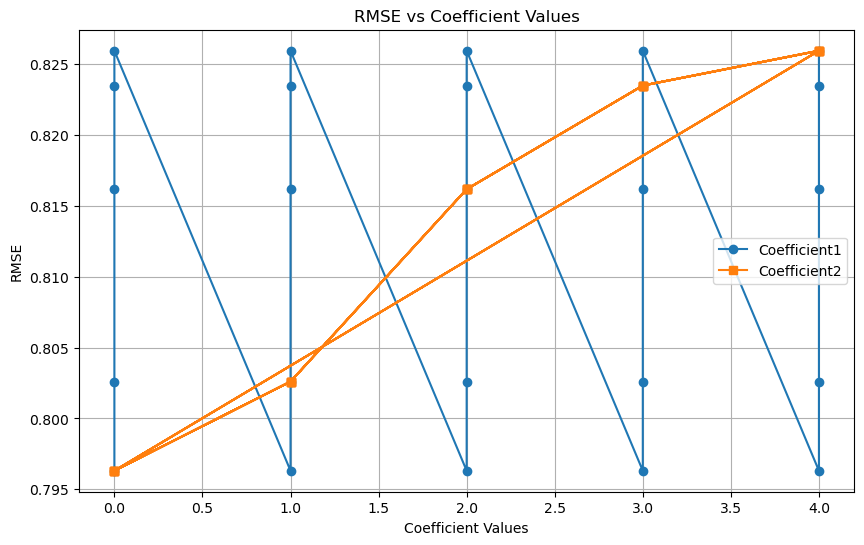

In [33]:
coef1_values = [item[0] for item in graphData]
coef2_values = [item[1] for item in graphData]
rmse_values = [item[2] for item in graphData]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(coef1_values, rmse_values, marker='o', label='Coefficient1')
plt.plot(coef2_values, rmse_values, marker='s', label='Coefficient2')
plt.xlabel('Coefficient Values')
plt.ylabel('RMSE')
plt.title('RMSE vs Coefficient Values')
plt.legend()
plt.grid(True)
plt.show()

In [34]:
def estimate_augment(user_id, movies):
    user_ratings = pd.merge(ratings[ratings['userId'] == user_id],
                            movie_metadata[['id', 'title']],
                            left_on='movieId',
                            right_on='id',
                            how='inner')
    user_ratings = user_ratings.drop('id', axis=1)
    user_ratings['movieId'] = user_ratings['movieId'].astype(int)

    reviewed_movie_ids = set(user_ratings['movieId'])
    pred_series = []
    for movie_id in movies['id']:
        if movie_id in reviewed_movie_ids:
            continue
        simTotal = weightedSum = 0
        sim_scores_row = list(enumerate(cosine_sim[indices[movie_id]]))
        for reviewed_id in reviewed_movie_ids:
            idx = indices[reviewed_id]
            if len(sim_scores_row) < 46488:
                continue
            if type(idx) != np.int64:
                continue
            sim_score = sim_scores_row[idx]
            simTotal += float(sim_score[1])
            weightedSum += float(sim_score[1]) * float(user_ratings[user_ratings['movieId'] == reviewed_id]['rating'])
        predictedRating = weightedSum / simTotal if simTotal != 0 else 0
        predictedRating = (predictedRating + svd_model_trained.predict(user_id, movie_id, rating,
                                                                       verbose=False).est) / 2
        pred_series.append((movie_id, predictedRating))

    pred_series = sorted(pred_series, key=lambda x: x[1], reverse=True)[:10]
    return pred_series

In [35]:
data = []
ratings_test = pd.merge(ratings_test, movie_metadata[['id']], left_on='movieId', right_on='id', how='inner')

for index, row in ratings_test.iterrows():
    user_id = row['userId']
    movie_id = row['movieId']
    rating = row['rating']
    predicted = estimate_augment(user_id, movie_metadata[movie_metadata['id'] == movie_id])[0][1]
    data.append((rating, predicted))

In [36]:
mse, rmse = calculate_mse_and_rmse(data)
print("MSE:", mse)
print("RMSE:", rmse)

MSE: 0.8631379885255805
RMSE: 0.9290521990316694


In [37]:
def recommend_switching(user_id):
    num_user_ratings = len(ratings[ratings['userId'] == user_id])
    if num_user_ratings > 7:
        return get_recommendations_user(user_id)
    else:
        return get_recommendations_content(user_id)

In [38]:
user_ids = ratings_test['userId'].unique()
ratings_test = pd.merge(ratings_test, movie_metadata[['id']], left_on='movieId', right_on='id', how='inner')
total, hit = 0, 0
for user_id in user_ids:
    first_row = recommend_switching(user_id).iloc[0]
    predicted_rating = first_row['predicted_rating']
    total = total + 1
    if predicted_rating > 3.5:
        hit = hit + 1
print("HitRatio: ", hit / total)
print("Hit:", hit)
print("Total: ", total)

HitRatio:  0.9954545454545455
Hit: 657
Total:  660


In [39]:
def recommend_weighted(user_id):
    predictions = []
    predictions_cf = get_recommendations_user(user_id)
    for index, row in predictions_cf.iterrows():
        prediction_cn = estimate_content_based(user_id, movie_metadata[movie_metadata['id'] == row['movieId']])
        if len(prediction_cn) != 0:
            prediction = pd.DataFrame(columns=['movieId', 'title', 'predicted_rating', 'actual_rating'])
            prediction['movieId'] = row['movieId']
            prediction['title'] = row['title']
            prediction_cn_val = prediction_cn[0][1]
            prediction['predicted_rating'] = 0.95 * row['predicted_rating'] + 0.05 * prediction_cn_val
            predictions.append(prediction)

    return pd.concat(predictions, ignore_index=True).sort_values(by='predicted_rating', ascending=False)

In [40]:
user_ids = ratings_test['userId'].unique()
ratings_test = pd.merge(ratings_test, movie_metadata[['id']], left_on='movieId', right_on='id', how='inner')
total, hit = 0, 0
for user_id in user_ids:
    prediction = recommend_weighted(user_id)
    if len(prediction) != 0:
        first_row = prediction.iloc[0]
        predicted_rating = first_row['predicted_rating']
        total = total + 1
        if predicted_rating > 3.5:
            hit = hit + 1


/var/folders/p8/ty6b1zbn4tq7l692h6f8ncpw0000gn/T/ipykernel_2618/2785693600.py:2: FutureWarning: Passing 'suffixes' which cause duplicate columns {'id_x'} in the result is deprecated and will raise a MergeError in a future version.
  ratings_test = pd.merge(ratings_test, movie_metadata[['id']], left_on='movieId', right_on='id', how='inner')


KeyboardInterrupt: 

In [ ]:
print("HitRatio: ", hit / total)
print("Hit:", hit)
print("Total: ", total)

In [ ]:
def reccommend_mix(user_id):
    predictions_ub = get_recommendations_user(user_id).iloc[:5]
    predictions_cn = get_recommendations_content(user_id).iloc[:5]
    predictions_cn  = predictions_cn.rename({'id': 'movieId'}, axis=1)
    return predictions_ub.append(predictions_cn).sort_values(by='predicted_rating', ascending=False)

In [ ]:
user_ids = ratings_test['userId'].unique()
ratings_test = pd.merge(ratings_test, movie_metadata[['id']], left_on='movieId', right_on='id', how='inner')
total, hit = 0, 0
for user_id in user_ids:
    prediction = reccommend_mix(user_id)
    if len(prediction) != 0:
        first_row = prediction.iloc[0]
        predicted_rating = first_row['predicted_rating']
        total = total + 1
        if predicted_rating > 3.5:
            hit = hit + 1

In [ ]:
print("HitRatio: ", hit / total)
print("Hit:", hit)
print("Total: ", total)